In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_results(run_ids):
    tr_dict = {'avg_length':'avg_req_length','avg_price':'avg_req_price','avg_num_trips':'num_req_completed','avg_online_ratio':'online_ratio','waiting_per_empty':'waiting_per_empty'}

    data = [pd.read_csv('results/run_'+run_id+'_per_taxi_aggregates.csv',index_col=0) for run_id in run_ids]
    distr = [json.load(open('results/run_'+run_id+'_per_taxi_distributions.json')) for run_id in run_ids]
    for column in [c for c in data[0].columns if ((c[0]=='a') or (c[0]=='w'))]:
        f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,5))
        for i in range(len(data)):
            d1 = data[i]
            ax1.plot(d1['timestamp'],d1[column],label=run_ids[i])
            ax1.set_xlabel('Time')
            ax1.set_ylabel(column)
            ax1.legend()

            d2 = distr[i]
            column2 = tr_dict[column]
            y,x=np.histogram([elem for elem in d2[column2] if not np.isnan(elem)])
            ax2.plot(x[1:],y,'-',label=run_ids[i])
            ax2.legend()
            ax2.set_xlabel(column2)
            ax2.set_ylabel('N('+column2+')')

# 500 taxis

Without pricing.

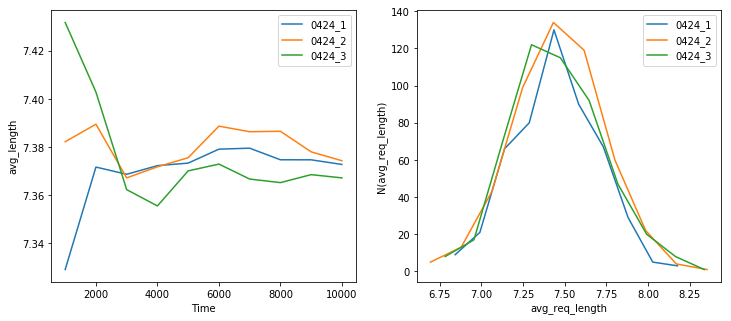

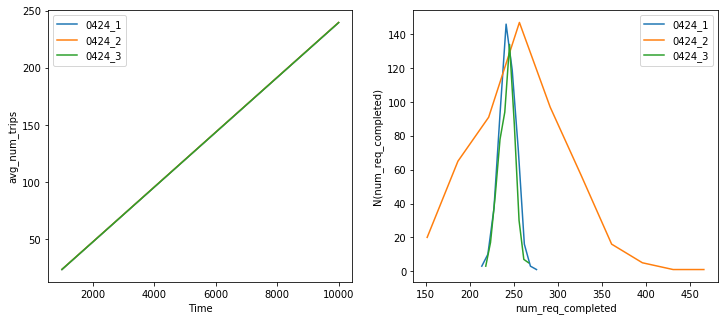

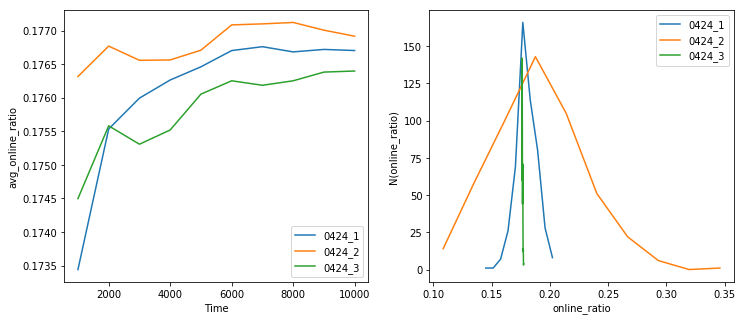

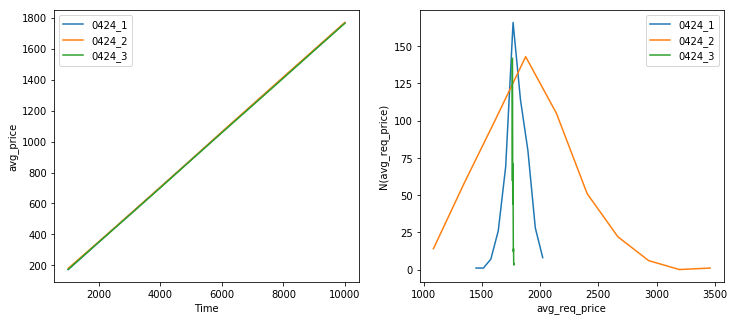

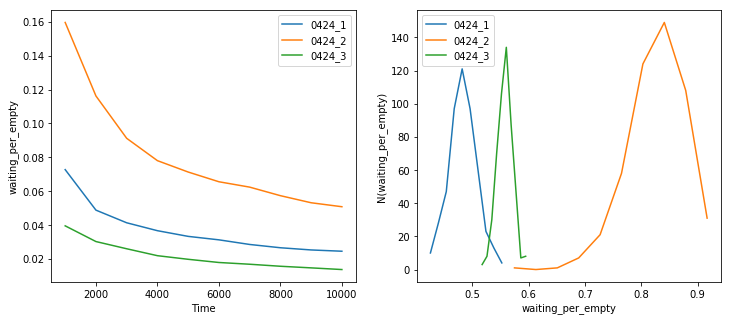

In [3]:
run_ids = ['0424_'+str(i) for i in range(1,4)]
plot_results(run_ids)

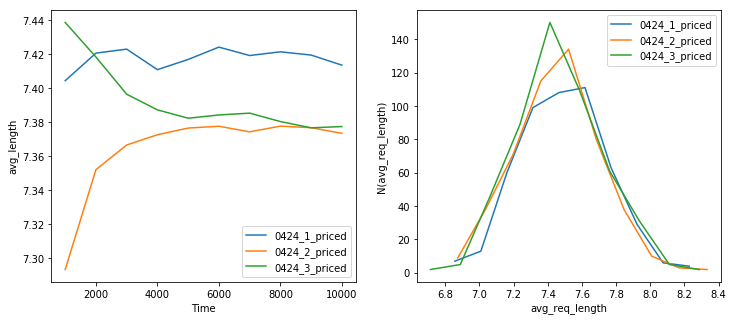

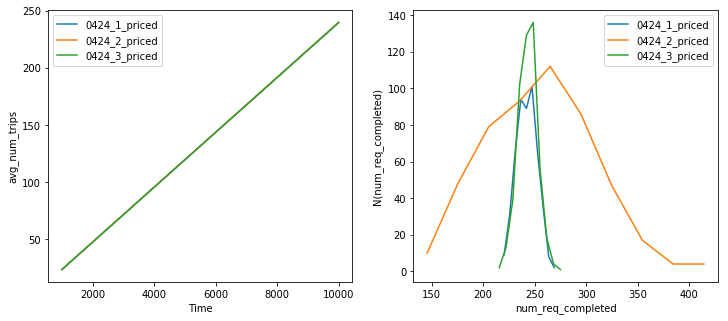

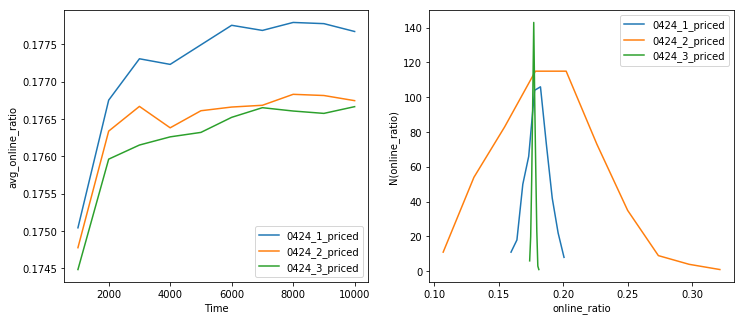

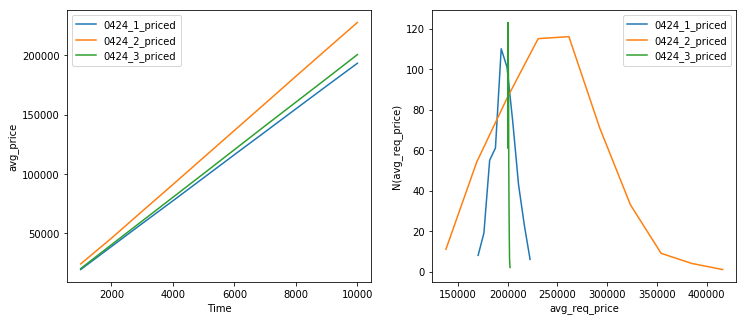

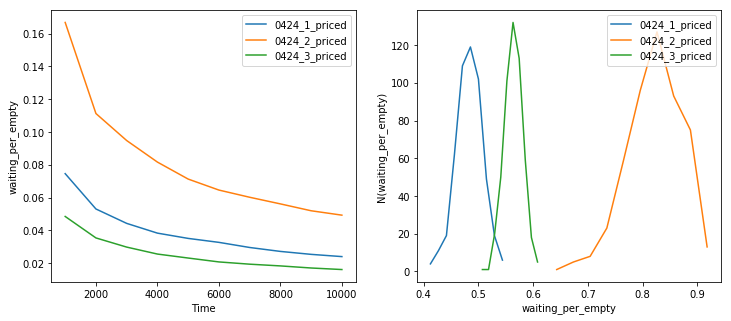

In [4]:
run_ids = ['0424_'+str(i)+'_priced' for i in range(1,4)]
plot_results(run_ids)

# 200 taxis

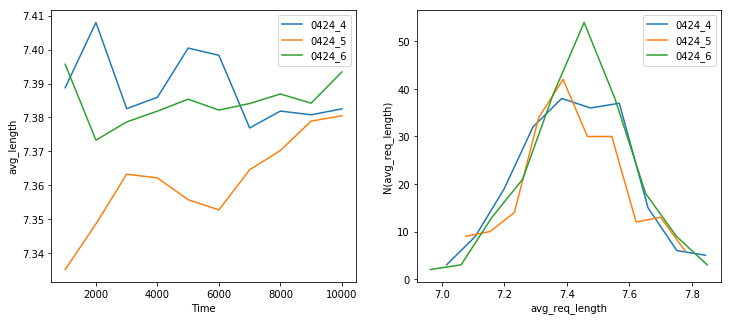

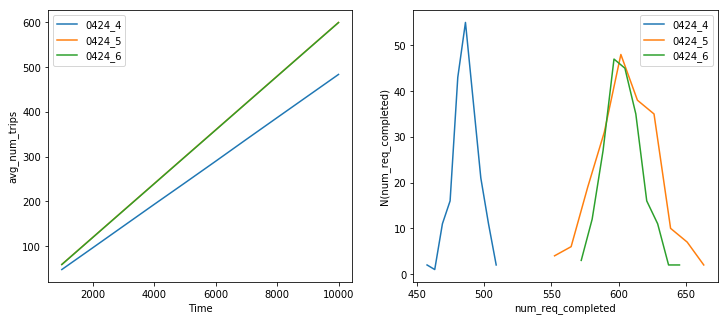

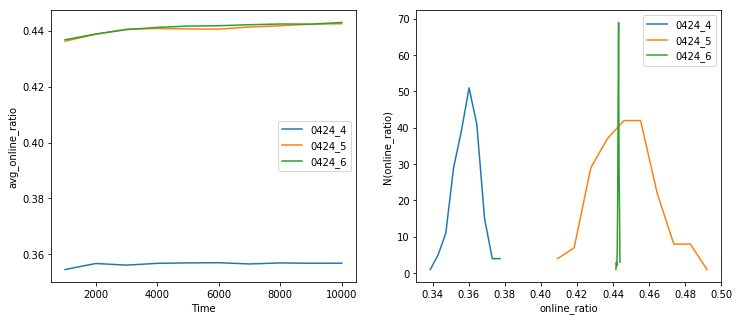

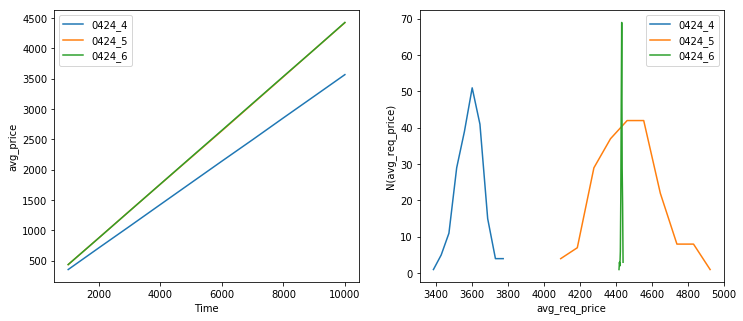

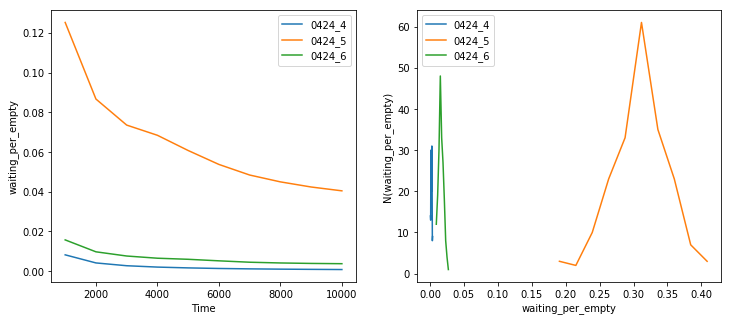

In [5]:
run_ids = ['0424_'+str(i) for i in range(4,7)]
plot_results(run_ids)

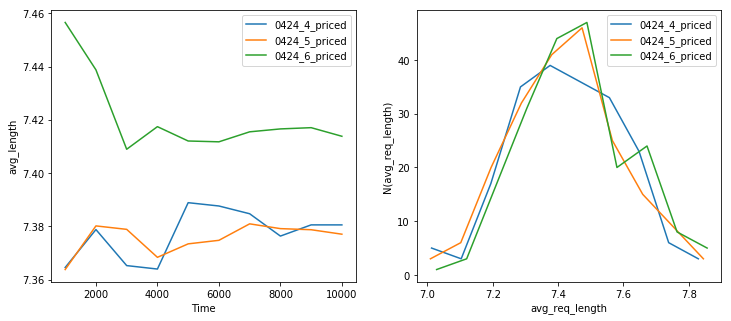

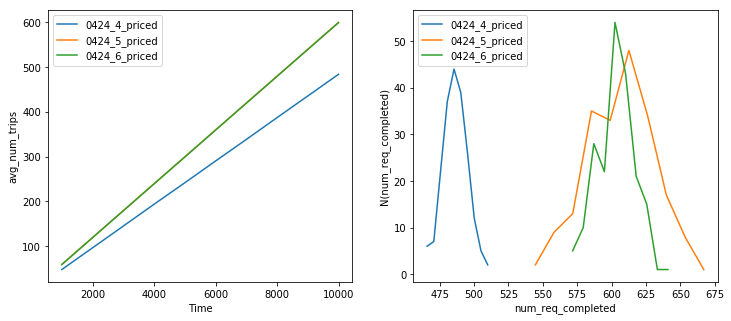

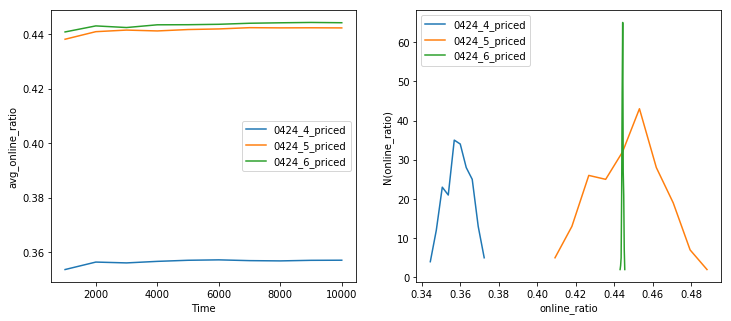

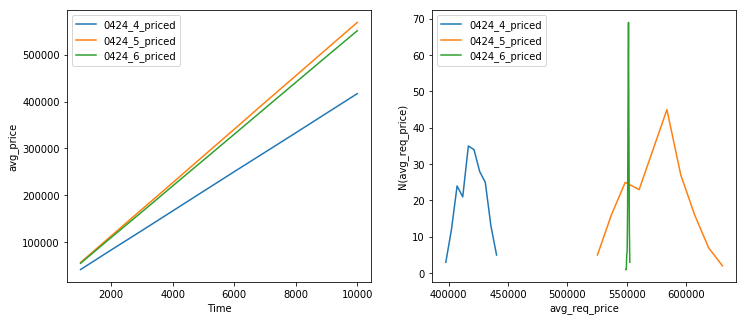

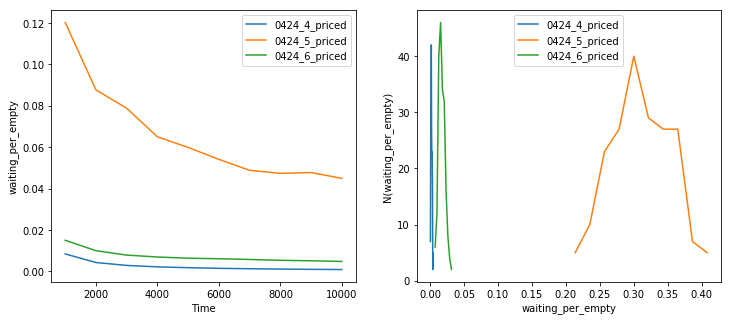

In [6]:
run_ids = ['0424_'+str(i)+'_priced' for i in range(4,7)]
plot_results(run_ids)